In [ ]:
!pip install -U scikit-learn
!pip install -U imbalanced-learn scikit-learn


Mounted at /content/drive
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 0.6358
Precision: 0.6074
Recall: 0.6358
F1-score: 0.6184

Classification Report:
               precision    recall  f1-score   support

           0       0.03      0.01      0.01       132
           1       0.42      0.40      0.41      3765
           2       0.73      0.80      0.77      8822
           3       0.26      0.12      0.16       981

    accuracy                           0.64     13700
   macro avg       0.36      0.33      0.34     13700
weighted avg       0.61      0.64      0.62     13700



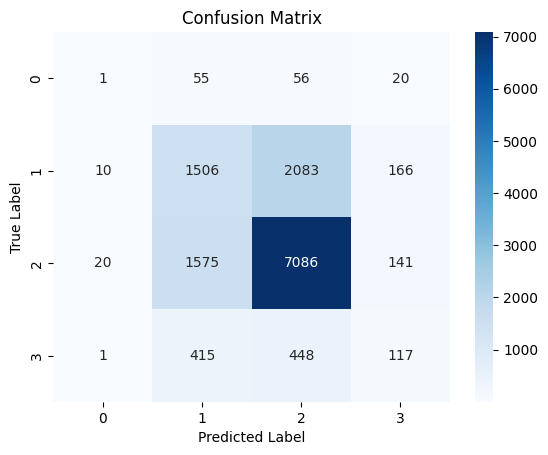

In [1]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from google.colab import drive
drive.mount('/content/drive')

# Assuming Google Drive is mounted and the CSV file path is defined
csv_file_path = '/content/drive/My Drive/Cleaned_data.csv'

# Read the CSV file directly into a DataFrame
data = pd.read_csv(csv_file_path)

# Selecting relevant features for the model
features = ['Number of vehicles involved', 'Crash year',
            'Day of the week', 'Month of year', 'Is weekend', 'TLA (Territorial local authority)',

            'Regional council', 'Road category', 'Intersection / midblock', 'Urban or open speed zone',
            'Posted speed limit', 'Junction type', 'Road curvature', 'Road feature', 'Gradient',
            'Surface type', 'Road type', 'Street lights', 'Number of lanes', 'Traffic control present',
            'Primary surface condition', 'Road markings', 'Natural Light', 'Primary weather',
            'Vehicle 1 type', 'Ethnicity', 'Gender', 'Road user type', 'Crash severity']
data = data[features]

# Handling missing values (Example approach, adjust according to your data)
data.fillna(method='ffill', inplace=True)

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

# Separating the target variable and features
X = data.drop('Crash severity', axis=1)
y = data['Crash severity']


# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(data.drop('Crash severity', axis=1))
y = data['Crash severity']


# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data to separate out a tuning set (10% of the original dataset)
X_tune, X_not_tune, y_tune, y_not_tune = train_test_split(X_train, y_train, test_size=0.90, random_state=42)  # Adjusted to keep 10% for tuning

# Apply SMOTE to the tuning data
smote = SMOTE(random_state=42)
X_tune_smote, y_tune_smote = smote.fit_resample(X_tune, y_tune)

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define a simplified hyperparameter grid
param_dist_simplified = {
    'n_estimators': [100, 200, 300],  # Fewer options
    'max_features': ['auto'],  # Simplified to default
    'max_depth': [10, 20, None],  # Fewer options
    'min_samples_split': [2, 4],  # Fewer options
    'min_samples_leaf': [1, 2],  # Fewer options
    'bootstrap': [True, False]
}

# Initialize the RandomizedSearchCV with fewer iterations and default CV folds
rf_random_simplified = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_simplified,
    n_iter=10,  # Fewer iterations
    cv=5,  # Default value for CV
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model with the simplified search
rf_random_simplified.fit(X_tune_smote, y_tune_smote)

# Extract the best estimator from the simplified random search
best_rf_simplified = rf_random_simplified.best_estimator_

# Use the best estimator to make predictions on the test set
y_pred = best_rf_simplified.predict(X_test)

# Then proceed with your evaluation using y_pred as before
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}")

# And so on with the rest of your evaluation code...

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
# Function to evaluate model performance across different hyperparameters
def evaluate_model_performance(clf, X_train, y_train, X_test, y_test, param_name, param_values):
    performance = {}
    for value in param_values:
        kwargs = {param_name: value}
        model = RandomForestClassifier(random_state=42, **kwargs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        performance[value] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted')
        }
    return performance

# Evaluating n_estimators
n_estimators_list = [50, 100, 200, 300]
n_estimators_performance = evaluate_model_performance(rf_clf, X_train, y_train, X_test, y_test, 'n_estimators', n_estimators_list)

# Evaluating max_depth
max_depth_values = [None, 10, 20, 30, 40, 50]
max_depth_performance = evaluate_model_performance(rf_clf, X_train, y_train, X_test, y_test, 'max_depth', max_depth_values)

# Evaluating min_samples_split and min_samples_leaf
min_samples_split_values = [2, 4, 6, 10]
min_samples_leaf_values = [1, 2, 4, 6]
split_performance = evaluate_model_performance(rf_clf, X_train, y_train, X_test, y_test, 'min_samples_split', min_samples_split_values)
leaf_performance = evaluate_model_performance(rf_clf, X_train, y_train, X_test, y_test, 'min_samples_leaf', min_samples_leaf_values)

# Function to print performance metrics
def print_performance(performance, param_name):
    for param_value, metrics in performance.items():
        print(f"{param_name}: {param_value}, Metrics: {metrics}")

# Print performance metrics for different parameters
print_performance(n_estimators_performance, "n_estimators")
print_performance(max_depth_performance, "max_depth")
print("min_samples_split performance:")
print_performance(split_performance, "min_samples_split")
print("\nmin_samples_leaf performance:")
print_performance(leaf_performance, "min_samples_leaf")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

n_estimators: 50, Metrics: {'Accuracy': 0.7020236731576938, 'Precision': 0.662162383047998, 'Recall': 0.7020236731576938, 'F1': 0.6521197554409495}
n_estimators: 100, Metrics: {'Accuracy': 0.7058419243986255, 'Precision': 0.6673183389617924, 'Recall': 0.7058419243986255, 'F1': 0.6519586384933789}
n_estimators: 200, Metrics: {'Accuracy': 0.709049255441008, 'Precision': 0.6729505229974171, 'Recall': 0.709049255441008, 'F1': 0.6533060639013121}
n_estimators: 300, Metrics: {'Accuracy': 0.7076746849942727, 'Precision': 0.671665581327608, 'Recall': 0.7076746849942727, 'F1': 0.6505243591805633}
max_depth: None, Metrics: {'Accuracy': 0.7058419243986255, 'Precision': 0.6673183389617924, 'Recall': 0.7058419243986255, 'F1': 0.6519586384933789}
max_depth: 10, Metrics: {'Accuracy': 0.682626956853761, 'Precision': 0.6167851047060953, 'Recall': 0.682626956853761, 'F1': 0.5896744923606355}
max_depth: 20, Metrics: {'Accuracy': 0.7024818633066056, 'Precision': 0.6729539863879352, 'Recall': 0.70248186330

In [ ]:
test_sizes = [0.2, 0.3, 0.4]  # Different ratios for testing

split_test_performance = {}

for test_size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=test_size, random_state=42)

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_split, y_train_split)
    y_pred_split = rf_model.predict(X_test_split)

    split_test_performance[test_size] = {
        'Accuracy': accuracy_score(y_test_split, y_pred_split),
        'Precision': precision_score(y_test_split, y_pred_split, average='weighted'),
        'Recall': recall_score(y_test_split, y_pred_split, average='weighted'),
        'F1': f1_score(y_test_split, y_pred_split, average='weighted')
    }

# Print performances for different splits
for test_size, metrics in split_test_performance.items():
    print(f"Test size: {test_size}, Metrics: {metrics}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test size: 0.2, Metrics: {'Accuracy': 0.7058419243986255, 'Precision': 0.6673183389617924, 'Recall': 0.7058419243986255, 'F1': 0.6519586384933789}
Test size: 0.3, Metrics: {'Accuracy': 0.7046276027083439, 'Precision': 0.6695132213484426, 'Recall': 0.7046276027083439, 'F1': 0.6492242575825625}
Test size: 0.4, Metrics: {'Accuracy': 0.7004581901489118, 'Precision': 0.6619556132470258, 'Recall': 0.7004581901489118, 'F1': 0.6429160348058368}


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 16}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6951
Precision: 0.6662
Recall: 0.6951
F1-score: 0.6237


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
                   precision    recall  f1-score   support

     Fatal Crash       0.00      0.00      0.00       132
     Minor Crash       0.66      0.20      0.30      3765
Non-Injury Crash       0.70      0.98      0.82      8822
   Serious Crash       0.45      0.11      0.17       981

        accuracy                           0.70     13700
       macro avg       0.45      0.32      0.32     13700
    weighted avg       0.67      0.70      0.62     13700



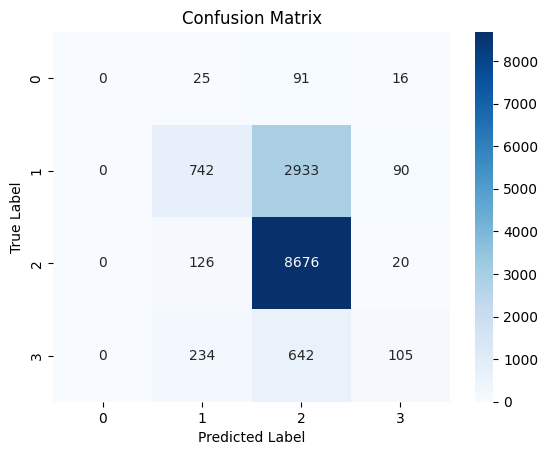

In [17]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from scipy import interp
import numpy as np

# Assuming Google Drive is mounted and CSV file path is defined

# Initialize an empty list to store the rows
rows = []

# Open the file and read it with the csv.reader
try:
    with open(csv_file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            rows.append(row)
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

# Convert the list of rows to a DataFrame if rows were read successfully
if rows:
    data = pd.DataFrame(rows[1:], columns=rows[0])
    # Selecting relevant features for the model
    features = ['Simple / complex crash', 'Number of vehicles involved', 'Crash year',
                'Day of the week', 'Month of year', 'Is weekend', 'TLA (Territorial local authority)',
                'Regional council', 'Road category', 'Deprivation mesh block deprivation index',
                'Intersection / midblock', 'Urban or open speed zone', 'Posted speed limit',
                'Junction type', 'Road curvature', 'Road feature', 'Gradient', 'Surface type',
                'Road type', 'Street lights', 'Number of lanes', 'Traffic control present',
                'Primary surface condition', 'Road markings', 'Natural Light', 'Primary weather',
                'Vehicle 1 type', 'Ethnicity', 'Gender', 'Road user type', 'Crash severity']

    data = data[features]

    # Separating the target variable before applying one-hot encoding
    target_variable = 'Crash severity'
    X = data.drop(target_variable, axis=1)
    y = data[target_variable]

    # Convert categorical variables to numerical using one-hot encoding
    X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Use only 1% of the training data for hyperparameter tuning
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.99, random_state=42)

# Define a hyperparameter distribution instead of a fixed grid
param_dist = {
    'max_depth': [None] + list(range(5, 21)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Reduced parallelism
random_search = RandomizedSearchCV(dt_clf, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=1, random_state=42)
random_search.fit(X_train_sample, y_train_sample)


# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize the Decision Tree Classifier with best hyperparameters
dt_clf_best = DecisionTreeClassifier(random_state=42, **best_params)

# Train the model on the full training set
dt_clf_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_clf_best.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display the Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




In [18]:
# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Function to evaluate Decision Tree model performance across different hyperparameter values
def evaluate_decision_tree_performance(param_name, param_values):
    performance = {}
    for value in param_values:
        dt_clf = DecisionTreeClassifier(random_state=42, **{param_name: value})
        dt_clf.fit(X_train, y_train)
        y_pred = dt_clf.predict(X_test)
        performance[value] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted')
        }
    return performance

# Define hyperparameter ranges
max_depth_values = [None] + list(range(5, 26, 5))
min_samples_split_values = range(2, 21, 4)
min_samples_leaf_values = range(1, 11, 2)
criterion_values = ['gini', 'entropy']

# Evaluate model performance for each hyperparameter
max_depth_performance = evaluate_decision_tree_performance('max_depth', max_depth_values)
min_samples_split_performance = evaluate_decision_tree_performance('min_samples_split', min_samples_split_values)
min_samples_leaf_performance = evaluate_decision_tree_performance('min_samples_leaf', min_samples_leaf_values)
criterion_performance = evaluate_decision_tree_performance('criterion', criterion_values)

# Print performances for different hyperparameters
def print_performance(performance, param_name):
    print(f"Performance for different values of {param_name}:")
    for param_value, metrics in performance.items():
        print(f"{param_name} = {param_value}, Metrics: {metrics}")

print_performance(max_depth_performance, "max_depth")
print_performance(min_samples_split_performance, "min_samples_split")
print_performance(min_samples_leaf_performance, "min_samples_leaf")
print_performance(criterion_performance, "criterion")

print("Sensitivity analysis completed.")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance for different values of max_depth:
max_depth = None, Metrics: {'Accuracy': 0.6197810218978103, 'Precision': 0.6200779714255849, 'Recall': 0.6197810218978103, 'F1': 0.6198528642866035}
max_depth = 5, Metrics: {'Accuracy': 0.6964963503649635, 'Precision': 0.6698083792424432, 'Recall': 0.6964963503649635, 'F1': 0.6269451186130264}
max_depth = 10, Metrics: {'Accuracy': 0.7184671532846715, 'Precision': 0.6920718592292815, 'Recall': 0.7184671532846715, 'F1': 0.6624786521889938}
max_depth = 15, Metrics: {'Accuracy': 0.710948905109489, 'Precision': 0.674090889725098, 'Recall': 0.710948905109489, 'F1': 0.6632706950120225}
max_depth = 20, Metrics: {'Accuracy': 0.6911678832116789, 'Precision': 0.6503763856588454, 'Recall': 0.6911678832116789, 'F1': 0.6557756112287442}
max_depth = 25, Metrics: {'Accuracy': 0.6732116788321167, 'Precision': 0.6377737850638573, 'Recall': 0.6732116788321167, 'F1': 0.647316416832042}
Performance for different values of min_samples_split:
min_samples_split =

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import randint

# Assuming 'X_encoded' and 'y' are already defined as your feature set and target variable after preprocessing

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Use only a small portion of the training data for hyperparameter tuning to save computation
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.99, random_state=42)

# Define a hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'max_depth': [None] + list(range(5, 21)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Perform hyperparameter tuning using RandomizedSearchCV on the sample
# Reduced parallelism
random_search = RandomizedSearchCV(dt_clf, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=1, random_state=42)
random_search.fit(X_train_sample, y_train_sample)

random_search.fit(X_train_sample, y_train_sample)

# Get the best hyperparameters from the random search
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Re-run the sensitivity analysis with the best hyperparameters across different test sizes
test_sizes = [0.2, 0.3, 0.4]  # Different ratios for testing
split_test_performance_dt = {}

for test_size in test_sizes:
    # Split the data with the current test size
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_encoded, y, test_size=test_size, random_state=42)

    # Initialize the Decision Tree Classifier with the best hyperparameters
    dt_model_best = DecisionTreeClassifier(random_state=42, **best_params)

    # Train the model with the best hyperparameters
    dt_model_best.fit(X_train_split, y_train_split)

    # Predict on the test set
    y_pred_split = dt_model_best.predict(X_test_split)

    # Calculate and store performance metrics
    split_test_performance_dt[test_size] = {
        'Accuracy': accuracy_score(y_test_split, y_pred_split),
        'Precision': precision_score(y_test_split, y_pred_split, average='weighted'),
        'Recall': recall_score(y_test_split, y_pred_split, average='weighted'),
        'F1': f1_score(y_test_split, y_pred_split, average='weighted')
    }

# Print performances for different test sizes with the best hyperparameters
for test_size, metrics in split_test_performance_dt.items():
    print(f"Test size: {test_size} - Metrics: {metrics}")


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 16}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test size: 0.2 - Metrics: {'Accuracy': 0.6951094890510949, 'Precision': 0.666152588613992, 'Recall': 0.6951094890510949, 'F1': 0.623730169057863}
Test size: 0.3 - Metrics: {'Accuracy': 0.6944525547445255, 'Precision': 0.6636337738011562, 'Recall': 0.6944525547445255, 'F1': 0.6227366773190056}
Test size: 0.4 - Metrics: {'Accuracy': 0.6922262773722627, 'Precision': 0.6444533191091998, 'Recall': 0.6922262773722627, 'F1': 0.6157733021010899}


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9197316968394074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9197316968394074
[LightGBM] [Warning] bagging_fraction is set=0.8749080237694725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8749080237694725
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9197316968394074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9197316968394074
[LightGBM] [Warning] bagging_fraction is set=0.8749080237694725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8749080237694725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022961 seconds

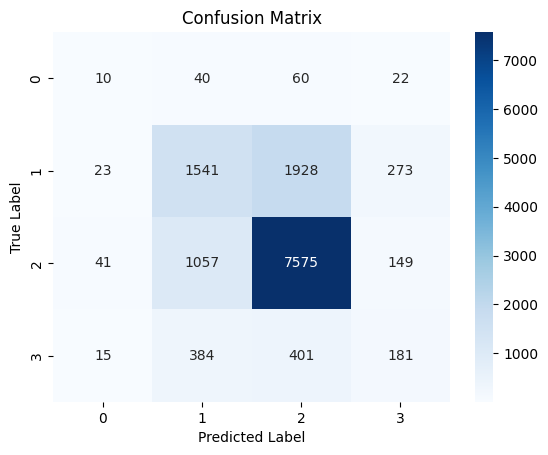

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from scipy.stats import randint, uniform
import numpy as np
import lightgbm as lgb
from itertools import cycle

# Assuming Google Drive is mounted and the CSV file path is defined
csv_file_path = '/content/drive/My Drive/Cleaned_data.csv'

# Read the CSV file directly into a DataFrame
data = pd.read_csv(csv_file_path)

# Selecting relevant features for the model
features = ['Number of vehicles involved', 'Crash year',
            'Day of the week', 'Month of year', 'Is weekend', 'TLA (Territorial local authority)',

            'Regional council', 'Road category', 'Intersection / midblock', 'Urban or open speed zone',
            'Posted speed limit', 'Junction type', 'Road curvature', 'Road feature', 'Gradient',
            'Surface type', 'Road type', 'Street lights', 'Number of lanes', 'Traffic control present',
            'Primary surface condition', 'Road markings', 'Natural Light', 'Primary weather',
            'Vehicle 1 type', 'Ethnicity', 'Gender', 'Road user type', 'Crash severity']
data = data[features]

# Handling missing values (Example approach, adjust according to your data)
data.fillna(method='ffill', inplace=True)

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

# Separating the target variable and features
X = data.drop('Crash severity', axis=1)
y = data['Crash severity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define a parameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 50),
    'feature_fraction': uniform(0.8, 0.2),
    'bagging_fraction': uniform(0.8, 0.2),
    'bagging_freq': randint(1, 10)
}

# Use a subset of data for tuning (1% of the training data)
X_sample, _, y_sample, _ = train_test_split(X_train_smote, y_train_smote, test_size=0.80, random_state=42)

# Initialize the LightGBM model
gbm = lgb.LGBMClassifier(objective='multiclass', num_class=len(np.unique(y_train_smote)), random_state=42)

# Reduced parallelism
random_search = RandomizedSearchCV(estimator=gbm, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=1, random_state=42)

# Replace special JSON characters in feature names
X_train_smote.columns = [col.replace('{', '').replace('}', '').replace(':', '').replace(';', '').replace(',', '') for col in X_train_smote.columns]
X_test.columns = [col.replace('{', '').replace('}', '').replace(':', '').replace(';', '').replace(',', '') for col in X_test.columns]

# After updating the feature names, rerun the model fitting process
random_search.fit(X_train_smote, y_train_smote)



# Best parameters found
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best parameters on the full training data
best_gbm = lgb.LGBMClassifier(**best_params, objective='multiclass', num_class=len(np.unique(y_train_smote)), random_state=42)
best_gbm.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred = best_gbm.predict(X_test)

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np

# Assuming 'X' and 'y' are your dataset's features and target variable
# Assuming 'best_params' contains the best hyperparameters found by RandomizedSearchCV

test_sizes = [0.2, 0.3, 0.4]
split_test_performance_lgbm = {}

for test_size in test_sizes:
    # Split the data with the current test size
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=test_size, random_state=42)

    # Apply SMOTE to balance the split training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_split, y_train_split)

    # Update feature names for LightGBM compatibility
    X_train_smote.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train_smote.columns]
    X_test_split.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_test_split.columns]

    # Initialize the LightGBM model with the best hyperparameters
    gbm_best = lgb.LGBMClassifier(**best_params, objective='multiclass', random_state=42, num_class=len(np.unique(y_train_smote)))

    # Train the model with the best hyperparameters on the split data
    gbm_best.fit(X_train_smote, y_train_smote)

    # Predict on the test set
    y_pred_split = gbm_best.predict(X_test_split)

    # Calculate and store performance metrics
    split_test_performance_lgbm[test_size] = {
        'Accuracy': accuracy_score(y_test_split, y_pred_split),
        'Precision': precision_score(y_test_split, y_pred_split, average='weighted'),
        'Recall': recall_score(y_test_split, y_pred_split, average='weighted'),
        'F1': f1_score(y_test_split, y_pred_split, average='weighted')
    }

# Print performances for different test sizes with the best hyperparameters
print("Sensitivity analysis for LightGBM with the best hyperparameters:\n")
for test_size, metrics in split_test_performance_lgbm.items():
    print(f"Test size: {test_size}")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print()  # For better readability between different test sizes


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8764923982534326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8764923982534326
[LightGBM] [Warning] bagging_fraction is set=0.9947511037682919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9947511037682919
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8764923982534326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8764923982534326
[LightGBM] [Warning] bagging_fraction is set=0.9947511037682919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9947511037682919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_encoded = pd.get_dummies(X)

# Assuming 'X' and 'y' are defined somewhere in your code
# X_encoded = pd.get_dummies(X)

# Function to sample values for continuous hyperparameters
def sample_uniform(start, width, num_samples=3):
    return np.random.uniform(start, start + width, num_samples)

# Evaluation function for LightGBM performance without varying test sizes
def evaluate_lightgbm_performance(X_encoded, y, hyperparameters, continuous_params):
    # Fixed test size for this evaluation
    test_size = 0.3  # You can adjust this fixed test size as needed

    # Splitting the data
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_encoded, y, test_size=test_size, random_state=42)
    smote = SMOTE()
    X_train_smote, y_train_smote = smote.fit_resample(X_train_split, y_train_split)

    # Correcting column sanitization for DataFrames converted from numpy arrays
    X_train_smote = pd.DataFrame(X_train_smote, columns=[col.replace('{', '').replace('}', '').replace(':', '').replace(';', '').replace(',', '') for col in X_train_split.columns])
    X_test_split = pd.DataFrame(X_test_split, columns=[col.replace('{', '').replace('}', '').replace(':', '').replace(';', '').replace(',', '') for col in X_test_split.columns])

    # Performance storage
    performance_metrics = {}

    for param, values in hyperparameters.items():
        if param in continuous_params:
            # Sample values for continuous parameters
            values = sample_uniform(*continuous_params[param], num_samples=3)

        for value in values:
            params = {'random_state': 42}
            params[param] = value
            # Adding other continuous parameters with fixed sampled value for this iteration
            for cp in ['feature_fraction', 'bagging_fraction']:
                if cp not in params:  # Ensure we don't overwrite the parameter being iterated
                    params[cp] = sample_uniform(*continuous_params[cp], 1)[0]

            # Model training and evaluation
            model = lgb.LGBMClassifier(**params, objective='multiclass', num_class=len(np.unique(y_train_smote)))
            model.fit(X_train_smote, y_train_smote)
            y_pred_split = model.predict(X_test_split)

            # Calculate and store performance metrics
            performance_metrics[f"{param}={value}"] = {
                'Accuracy': accuracy_score(y_test_split, y_pred_split),
                'Precision': precision_score(y_test_split, y_pred_split, average='weighted'),
                'Recall': recall_score(y_test_split, y_pred_split, average='weighted'),
                'F1': f1_score(y_test_split, y_pred_split, average='weighted')
            }

    # Print performance metrics for each hyperparameter setting
    for setting, metrics in performance_metrics.items():
        print(f"Setting: {setting}, Metrics: {metrics}")

# Hyperparameters and continuous parameters definition
hyperparameters = {
    'learning_rate': [0.1, 0.2, 0.3],
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 10, 15],
    'bagging_freq': [1, 5, 10]  # Discrete values for bagging_freq
}
continuous_params = {
    'feature_fraction': (0.8, 0.2),
    'bagging_fraction': (0.8, 0.2)
}

# Assuming 'X_encoded' and 'y' are defined earlier in your code
evaluate_lightgbm_performance(X_encoded, y, hyperparameters, continuous_params)


[LightGBM] [Warning] feature_fraction is set=0.860173863334473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860173863334473
[LightGBM] [Warning] bagging_fraction is set=0.8351249811272536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8351249811272536
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.860173863334473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860173863334473
[LightGBM] [Warning] bagging_fraction is set=0.8351249811272536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8351249811272536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 12314